In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
import datetime
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10

# load dataset from csv file

In [2]:
# test= pd.read_csv('/media/atif/BE0E05910E0543BD/University of Bremen MSc/masters_thesis/IAT_sebastian/dataset_26_april_3.csv')

test=pd.read_csv('E:/University of Bremen MSc/masters_thesis/IAT_sebastian/dataset_26_april_3.csv')

# converting unix time format to date time format

In [3]:
longTime=test.loc[0:,['longTime']]
longTime=longTime.as_matrix()
a=[]
date_time_array=[]
for k in longTime:
    a=np.append(a,k)
str_time=[]
correct_longtime=[]
datetime_time=[]
count=0
for b in a:
    b=int(b) # make plain integer
    str_b=str(b)
    c=str_b[-3:]
    new_str_b=str_b.replace(c, '',1)
    new_str_b_time=int(new_str_b)
    correct_longtime.append(new_str_b_time)
    now_time=datetime.datetime.fromtimestamp(new_str_b_time)
    convert_time=now_time.strftime('%Y-%m-%d %H:%M')
    str_time.append(convert_time)
# print(str_time)
test_new = test.assign(stringTime=str_time,correct_longtime=correct_longtime) # here new column in the panda dataframe for string_time has added

C:\Users\atif\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [4]:
test_new['dateTime'] =  pd.to_datetime(test_new['stringTime'], format='%Y-%m-%d %H:%M')

In [5]:
test_new = test_new.set_index('dateTime') # make dataTime column as index of the dataframe test_new

In [6]:
test_new.shape #ROWS, COLUMNS

(25000, 4222)

# making time series using important feature

In [84]:
multivariate_column_label=['DEWIHOBT9_I0','AEDATZ_HO_V0','RWWIHOB_HWT0','RWWIHOB_MWT0',
                           'AEDAHO_T9_V2','AEWIHO_T9AV2'] # choose column with which the following work will be conducted
# multivariate_column_label=['DEWIHOBT9_I0','AEDATZ_HO_V0','AEDAHO_T9_V2','AEWIHO_T9AV2']
# 'RWWIHOB_HWT0','RWWIHOB_MWT0','AEWIHO_T9AV2','AEDAHO_T9_V2'

# multivariate_column_label=['DEWIHOBT9_I0','AEDATZ_HO_V0','AEDABL1_40V0','AEDABL2_40V0','AEDABL0_20V0',
#                         'RWWIHOB_HWT0','RWWIHOB_MWT0','AEWIHO_T9AV2','AEDAHO_T9_V2']
size_column = len(multivariate_column_label)
print(size_column)

6


In [85]:
multivariate_data=test_new.iloc[2000:7000][multivariate_column_label]
multivariate_data=multivariate_data.loc[::-1]
print(multivariate_data.head())

                     DEWIHOBT9_I0  AEDATZ_HO_V0  RWWIHOB_HWT0  RWWIHOB_MWT0  \
dateTime                                                                      
2019-04-06 00:21:00         100.0     40.574666     94.408986     95.920205   
2019-04-06 00:22:00         100.0     39.990227     94.313021     95.839281   
2019-04-06 00:23:00         100.0     39.577443     94.269031     95.820845   
2019-04-06 00:24:00         100.0     39.685303     94.142675     95.668621   
2019-04-06 00:25:00         100.0     39.782918     93.993123     95.543627   

                     AEDAHO_T9_V2  AEWIHO_T9AV2  
dateTime                                         
2019-04-06 00:21:00     72.427071     76.598087  
2019-04-06 00:22:00     71.620643     76.358689  
2019-04-06 00:23:00     70.606738     77.241097  
2019-04-06 00:24:00     70.531626     77.062413  
2019-04-06 00:25:00     70.692115     76.297974  


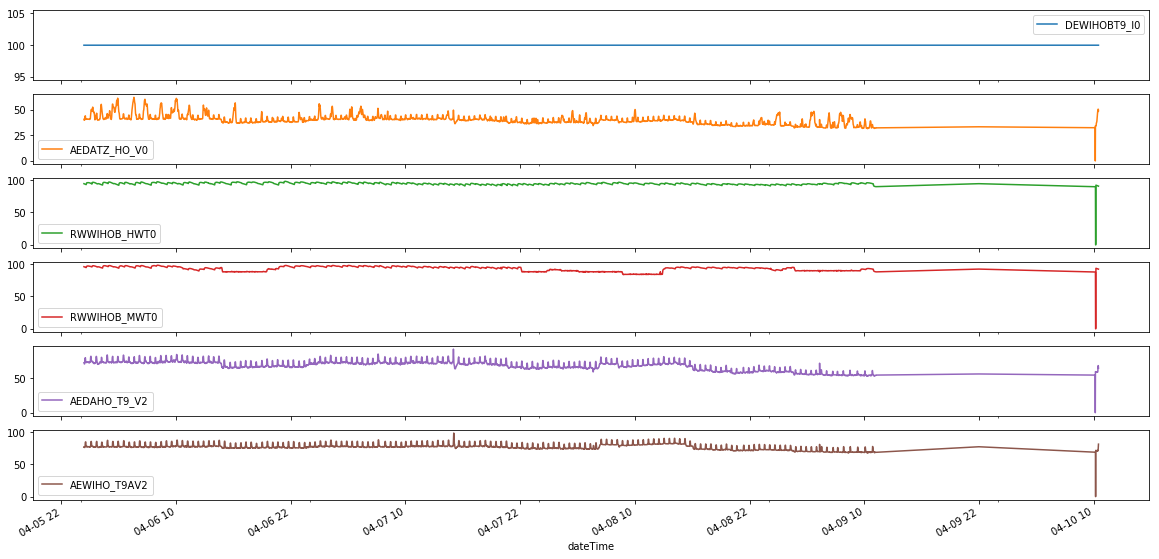

In [86]:
ax = multivariate_data.plot(subplots=True, layout=(size_column,1))
plt.rcParams['figure.figsize'] =(20,40)
# plt.savefig('E:/University of Bremen MSc/masters_thesis/forecasting_sensor_data_Salzgitter_AG/images_from_training/multivariate_data_regression.png')
plt.rcParams['figure.figsize'] =(20,10)
plt.show()

In [87]:
zero_index=[]
zero_index=np.array(zero_index)
for index, value in multivariate_data.iterrows():
    for i , v in enumerate(value):
        if i == 0  and v == 0.0:
#             print('index: ',index)
            zero_index=np.append(zero_index,index)

print('size of zero_index: ',zero_index.size)

size of zero_index:  0


In [88]:
if zero_index.size > 0:
    multivariate_data_modify = multivariate_data.drop(zero_index,axis=0) # axis= 0 means row indiated. 1 means column indicated
else:
    multivariate_data_modify = multivariate_data

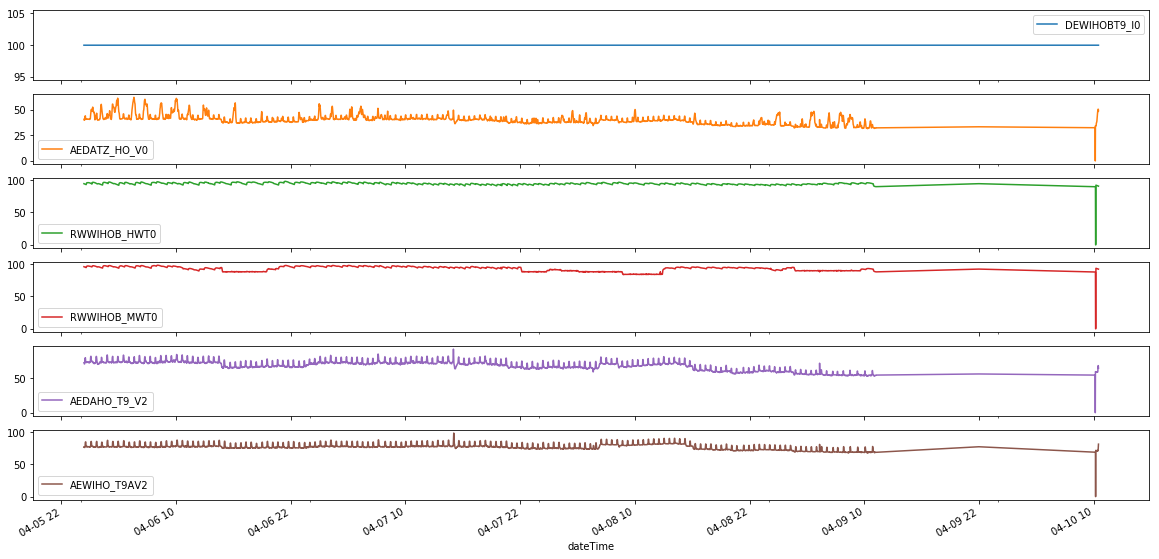

In [89]:
bx = multivariate_data_modify.plot(subplots=True, layout=(size_column,1))
plt.rcParams['figure.figsize'] =(20,10)
plt.show()

In [90]:
from numpy import nan
multivariate_data_drop_zero= multivariate_data_modify.replace(0,nan)
multivariate_data_drop_zero=multivariate_data_drop_zero.dropna(how='any',axis=0)

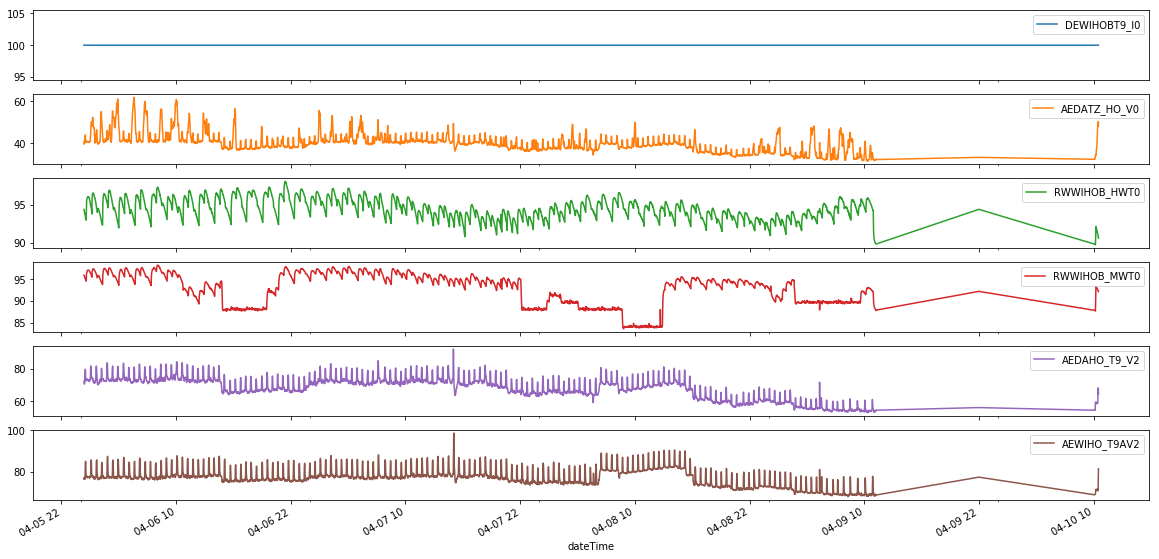

In [91]:
cx = multivariate_data_drop_zero.plot(subplots=True, layout=(size_column,1))
# plt.legend(loc='upper left')
plt.rcParams['figure.figsize'] =(20,10)
plt.show()

In [92]:
print('shape of multivariate_data: ',multivariate_data.shape)
print('shape of multivariate_data_modify: ', multivariate_data_modify.shape)
print('shape of multivariate_data_drop_zero: ',multivariate_data_drop_zero.shape)

shape of multivariate_data:  (5000, 6)
shape of multivariate_data_modify:  (5000, 6)
shape of multivariate_data_drop_zero:  (4997, 6)


In [93]:
# dataset=np.array(multivariate_data_mean)
dataset=np.array(multivariate_data_drop_zero)

NumberOfElements=int(len(dataset)*0.9)
print('dataset length: ',len(dataset))
print('Number of Elements for training: ',NumberOfElements)

multiple_ip_train_data=dataset[0:NumberOfElements]
print(multiple_ip_train_data.shape)
multiple_ip_test_set=dataset[NumberOfElements:len(dataset)]
print(multiple_ip_test_set.shape)

dataset length:  4997
Number of Elements for training:  4497
(4497, 6)
(500, 6)


In [94]:
# # remove this line if you want do not want to count mean. Just comment it and uncomment the below lines.
# multi_mean=multivariate_data.mean()
# multivariate_data_mean= multivariate_data.replace(0,multi_mean)

In [95]:
# multivariate_data_mean.plot()
# plt.show()

# Do normalization

In [38]:
# from sklearn import preprocessing

# min_max_scaler = preprocessing.MinMaxScaler()
# np_scaled = min_max_scaler.fit_transform(multivariate_data_mean)
# col_label=['AEDATZ_HO_V0','AEWIHO_T9AV2','AEWIHOAVABV2','RWWIHOA_HWT0','AEWIHOAKZ_V0','RWWIHOA_MWT0','AEDAHO_T9_V2']
# df_normalized = pd.DataFrame(np_scaled,index=multivariate_data.index,columns=col_label)

# function to make train and test dataset usable for conv LSTM

In [39]:
# print('multiple_ip_train_data: \n',multiple_ip_train_data[0:8])
# print('multiple ip train data shape: ',multiple_ip_train_data.shape,'\tsize: ',multiple_ip_train_data.size,'\tdimesnion: ',multiple_ip_train_data.ndim)

### Understanding function

In [45]:
# split a multivariate sequence into samples
from numpy import array
def split_sequence(sequence, n_steps):
    print('length of sequence',len(sequence))
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        print('end_ix: ',end_ix)
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix,:-1], sequence[end_ix,-1]
        print('seq_x: \n',seq_x,'\nseq_y: \n',seq_y)
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# a=array([[1,2,3,4,5,6,7],[8,9,10,11,12,13,14],[1,20,30,40,50,60,70]])
# print('printing array a: \n',a)
# print(' array a shape:',a.shape,'\tsize: ',a.size,'\tdimension: ',a.ndim )
# step=1
# train_a,train_b=split_sequence(a,step)
# print('printing array train_a: \n',train_a)
# print(print(' array train_a shape:',train_a.shape,'\tsize: ',train_a.size,'\tdimension: ',train_a.ndim ))
# print('printing array train_b: \n',train_b)
# print(print(' array train_b shape:',train_b.shape,'\tsize: ',train_b.size,'\tdimension: ',train_b.ndim ))

In [23]:
# n_features_a=train_a.shape[-1]
# n_seq_a=1
# n_row_a=1
# n_steps_a=1
# train_a_reshape = train_a.reshape((train_a.shape[0], n_seq_a, n_row_a, n_steps_a, n_features_a))

# print('printing array train_a_reshape: \n',train_a_reshape)
# print(print(' array train_a_reshape shape:',train_a_reshape.shape,'\tsize: ',train_a_reshape.size,'\tdimension: ',train_a_reshape.ndim ))

In [76]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
 
# split a multivariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix,:-1], sequence[end_ix,-1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_1 = 4
# split into samples
X_Conv_Lstm, y_Conv_Lstm = split_sequence(multiple_ip_train_data, n_steps_1)
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = X_Conv_Lstm.shape[2]
n_seq = 2
n_steps_2 = 2
n_rows=1

In [77]:
X_Conv_Lstm_train = X_Conv_Lstm.reshape((X_Conv_Lstm.shape[0], n_seq, n_rows, n_steps_2, n_features))

In [78]:
print('X_Conv_Lstm shape: ',X_Conv_Lstm.shape,'\tX_Conv_Lstm size: ',X_Conv_Lstm.size,'\tX_Conv_Lstm dimension: ',X_Conv_Lstm.ndim)
print('X_Conv_Lstm_train shape: ',X_Conv_Lstm_train.shape,'\tX_Conv_Lstm_train size: ',X_Conv_Lstm_train.size,'\tX_Conv_Lstm_train dimension: ',X_Conv_Lstm_train.ndim)

X_Conv_Lstm shape:  (4494, 4, 3) 	X_Conv_Lstm size:  53928 	X_Conv_Lstm dimension:  3
X_Conv_Lstm_train shape:  (4494, 2, 1, 2, 3) 	X_Conv_Lstm_train size:  53928 	X_Conv_Lstm_train dimension:  5


In [79]:
# define model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

lr = 0.01

def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

batch_size=32
epochs= 30

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps_2, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
# fit model
train_model=model.fit(X_Conv_Lstm_train, y_Conv_Lstm, batch_size=batch_size, epochs=epochs, verbose=1,
         callbacks=[LearningRateScheduler(lr_schedule),
                     ModelCheckpoint('/media/atif/BE0E05910E0543BD/University of Bremen MSc/masters_thesis/forecasting_sensor_data_Salzgitter_AG/trained_model_file/conv_LSTM_norm_100.h5', save_best_only=True)])

Epoch 1/30
4494/4494 [==============================] - 2s 390us/step - loss: 193.9503 - acc: 0.0000e+00
Epoch 2/30
1184/4494 [======>.......................] - ETA: 0s - loss: 5.7316 - acc: 0.0000e+00

C:\Users\atif\Anaconda3\lib\site-packages\keras\callbacks.py:434: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


4494/4494 [==============================] - 1s 132us/step - loss: 5.7927 - acc: 0.0000e+00
Epoch 3/30
4494/4494 [==============================] - 1s 125us/step - loss: 5.6347 - acc: 0.0000e+00
Epoch 4/30
4494/4494 [==============================] - 1s 126us/step - loss: 5.3320 - acc: 0.0000e+00
Epoch 5/30
4494/4494 [==============================] - 1s 124us/step - loss: 5.1366 - acc: 0.0000e+00
Epoch 6/30
4494/4494 [==============================] - 1s 125us/step - loss: 5.0023 - acc: 0.0000e+00
Epoch 7/30
4494/4494 [==============================] - 1s 133us/step - loss: 5.1440 - acc: 0.0000e+00
Epoch 8/30
4494/4494 [==============================] - 1s 164us/step - loss: 5.1232 - acc: 0.0000e+00
Epoch 9/30
4494/4494 [==============================] - 1s 134us/step - loss: 4.8403 - acc: 0.0000e+00
Epoch 10/30
4494/4494 [==============================] - 1s 126us/step - loss: 4.7875 - acc: 0.0000e+00
Epoch 11/30
4494/4494 [==============================] - 1s 125us/step - loss: 4.39

In [80]:
X_Conv_Lstm_test, y_Conv_Lstm_test = split_sequence(multiple_ip_test_set, n_steps_1)

x_input = X_Conv_Lstm_test.reshape((X_Conv_Lstm_test.shape[0], n_seq, 1, n_steps_2, X_Conv_Lstm_test.shape[2]))

In [81]:
from keras.models import load_model

# load_trained_model=load_model('/media/atif/BE0E05910E0543BD/University of Bremen MSc/masters_thesis/forecasting_sensor_data_Salzgitter_AG/trained_model_file/conv_LSTM_norm_100.h5')

yhat = model.predict(x_input, verbose=1)
# print(yhat)

496/496 [==============================] - 0s 577us/step


In [82]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#Print MSE to see how good the model is
Error = mean_squared_error(y_Conv_Lstm_test,yhat)
print('mean squared error: ',Error)
print('RMSE Error: ',sqrt(Error))

mean squared error:  2.1375392914931894
RMSE Error:  1.462032589066738


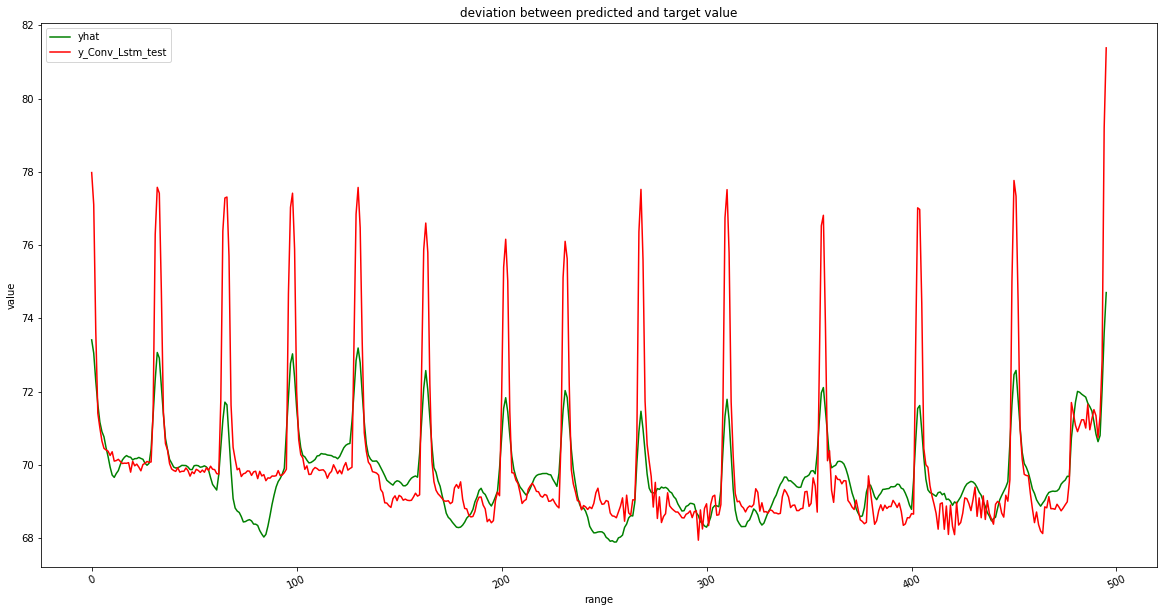

In [83]:
# my_data_1.index[0:-1]
plt.plot(yhat,color='green')
plt.plot(y_Conv_Lstm_test,color='red')
plt.xticks( rotation=25)
plt.title('deviation between predicted and target value')
plt.ylabel('value')
plt.xlabel('range')
plt.legend(['yhat', 'y_Conv_Lstm_test'], loc='upper left')
plt.show()

In [24]:
# count=0
# for i,j in multivariate_data.iterrows():
#     for o in j:
#         if o==0:
#             print(count,'\t',i,'\t',o)
#             count+=1
    

In [25]:
# multivariate_data_mean.max()

In [26]:
# df_normalized.head()

In [27]:
# head=multivariate_data_mean.head()
# print(head)

In [28]:
# # To get max value from each column
# temp=0
# max_lst=[]
# for idx,val in enumerate(col_label):
#     values=multivariate_data_mean[val]
#     for item in values:
#         if item>temp:
#             temp=item
#         else:
#             pass
#     s=[val,temp]
#     max_lst.append(s)
#     temp=0
# print(temp)

In [29]:
# max_lst[0][1]

# finding max value

In [38]:
# finding max value from each column
max_array=[]
i=0
for idx,val in enumerate(list(multivariate_data_mean.columns)):
    x=multivariate_data_mean[val].max()
    q=[val,x]
    max_array.append(q)

In [39]:
print(max_array)

[['AEDATZ_HO_V0', 67.61101867732815], ['AEWIHO_T9AV2', 99.03705800931169], ['AEWIHOAVABV2', 96.347427549395], ['RWWIHOA_HWT0', 99.30801700284124], ['AEWIHOAKZ_V0', 92.0322826114535], ['RWWIHOA_MWT0', 99.51592757474876], ['AEDAHO_T9_V2', 99.4516393320581]]


In [43]:
target_column_max_value=max_array[-1][-1]

In [44]:
target_column_max_value

99.4516393320581

# Unnormalized predicted and actual output array

In [46]:
unnormalized_yhat=yhat*target_column_max_value
unnormalized_y_Conv_Lstm_test=y_Conv_Lstm_test*target_column_max_value

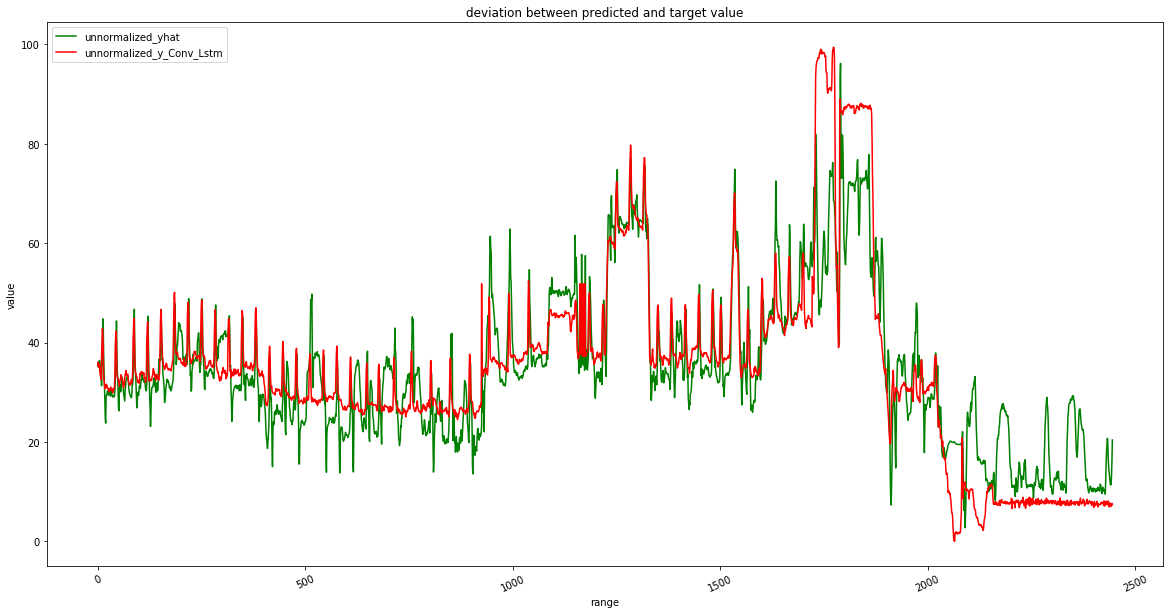

In [47]:
plt.plot(unnormalized_yhat,color='green')
plt.plot(unnormalized_y_Conv_Lstm_test,color='red')
plt.xticks( rotation=25)
plt.title('deviation between predicted and target value')
plt.ylabel('value')
plt.xlabel('range')
plt.legend(['unnormalized_yhat', 'unnormalized_y_Conv_Lstm'], loc='upper left')
plt.show()

In [48]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#Print MSE to see how good the model is
Error = mean_squared_error(unnormalized_y_Conv_Lstm_test,unnormalized_yhat)
print('mean squared error: ',Error)
print('RMSE Error: ',sqrt(Error))

mean squared error:  84.43641866138238
RMSE Error:  9.188929135725358


In [201]:
test_new.head()

,row ID,longTime,AEAGHOAWE2T1,AEAGHOAWE2A0,AEAGHOAWE2T0,AEAGHOAWE1A0,AEAGHOAWE1T1,AEAGHOAWE1T0,AEAGHOAWE3T0,AEAGHOAWE3A0,...,RWWIHOT9_RV0,RWWIHOT10RV0,RWWIHOTSURV0,RWWIHOTSUMV0,RWWIHO_VERV0,RWWIHO_UESV0,RWWIHOSUMAV0,stringTime,correct_longtime,dateTime
0,Row0,1555311120000,74.451979,19.111606,98.371549,18.819155,93.337524,69.969526,95.445534,7.802471,...,22.338103,75.685755,73.945394,0.000000,0.000000,0.000000,0.000000,2019-04-15 08:52,1555311120,2019-04-15 08:52:00
1,Row1,1555311060000,73.933103,18.088026,98.186038,18.943335,92.869960,69.969526,95.445534,12.856953,...,26.967692,75.685755,66.649583,56.385432,68.734584,9.127668,2.275890,2019-04-15 08:51,1555311060,2019-04-15 08:51:00
2,Row2,1555311000000,73.471742,25.843589,98.371549,33.166077,92.343799,69.969526,95.628479,21.591973,...,26.851837,75.685755,66.587330,56.402658,68.853203,9.136596,2.275735,2019-04-15 08:50,1555311000,2019-04-15 08:50:00
3,Row3,1555310940000,73.010381,27.772137,98.371549,35.991205,91.876236,69.850105,95.607810,19.492370,...,26.266369,75.685755,66.373907,56.527297,69.391059,9.138625,2.281882,2019-04-15 08:49,1555310940,2019-04-15 08:49:00
4,Row4,1555310880000,72.549020,18.402556,98.186038,19.591687,91.408672,69.969526,95.607810,8.014898,...,26.605640,75.685755,66.529224,56.640964,69.299560,9.121256,2.269317,2019-04-15 08:48,1555310880,2019-04-15 08:48:00


In [202]:
df = test.drop(test.columns[[0]], axis=1)

In [203]:
df.head()

,longTime,AEAGHOAWE2T1,AEAGHOAWE2A0,AEAGHOAWE2T0,AEAGHOAWE1A0,AEAGHOAWE1T1,AEAGHOAWE1T0,AEAGHOAWE3T0,AEAGHOAWE3A0,AEAGHOAWE3T1,...,RWWIHOUT10V1,RWWIHOT7_RV0,RWWIHOT8_RV0,RWWIHOT9_RV0,RWWIHOT10RV0,RWWIHOTSURV0,RWWIHOTSUMV0,RWWIHO_VERV0,RWWIHO_UESV0,RWWIHOSUMAV0
0,1555311120000,74.451979,19.111606,98.371549,18.819155,93.337524,69.969526,95.445534,7.802471,57.766387,...,0.0,92.632593,44.620461,22.338103,75.685755,73.945394,0.000000,0.000000,0.000000,0.000000
1,1555311060000,73.933103,18.088026,98.186038,18.943335,92.869960,69.969526,95.445534,12.856953,58.231774,...,0.0,82.082055,53.182296,26.967692,75.685755,66.649583,56.385432,68.734584,9.127668,2.275890
2,1555311000000,73.471742,25.843589,98.371549,33.166077,92.343799,69.969526,95.628479,21.591973,58.231774,...,0.0,82.098144,53.029243,26.851837,75.685755,66.587330,56.402658,68.853203,9.136596,2.275735
3,1555310940000,73.010381,27.772137,98.371549,35.991205,91.876236,69.850105,95.607810,19.492370,58.231774,...,0.0,82.074011,53.015226,26.266369,75.685755,66.373907,56.527297,69.391059,9.138625,2.281882
4,1555310880000,72.549020,18.402556,98.186038,19.591687,91.408672,69.969526,95.607810,8.014898,58.697162,...,0.0,82.078296,53.172932,26.605640,75.685755,66.529224,56.640964,69.299560,9.121256,2.269317


In [210]:
# finding max value from each column
test_array=[]
i=0
for idx,val in enumerate(list(df.columns)):
    x=df[val].max()
    q=[val,x]
    test_array.append(q)
test_array=np.array(test_array)
print(test_array)
    

[['longTime' '1555311120000']
 ['AEAGHOAWE2T1' '98.67343689926952']
 ['AEAGHOAWE2A0' '100.0']
 ...
 ['RWWIHO_VERV0' '82.07662441475391']
 ['RWWIHO_UESV0' '24.143981819657487']
 ['RWWIHOSUMAV0' '80.343808413699']]


In [211]:
for i in test_array:
    print(i)

['longTime' '1555311120000']
['AEAGHOAWE2T1' '98.67343689926952']
['AEAGHOAWE2A0' '100.0']
['AEAGHOAWE2T0' '98.68047251105995']
['AEAGHOAWE1A0' '100.0']
['AEAGHOAWE1T1' '95.32436459606436']
['AEAGHOAWE1T0' '71.79520644194703']
['AEAGHOAWE3T0' '99.32869318959595']
['AEAGHOAWE3A0' '100.0']
['AEAGHOAWE3T1' '95.40444935956188']
['AEAGHOAWE_A2' '100.0']
['AEAGHOAWE_A1' '100.0']
['AEAGHOAWE_A0' '97.79370330347851']
['AEAGHOAWE_T3' '89.41684665226782']
['AEAGTHHPF2T0' '98.90628952682538']
['AEAGHOA_S2G0' '0.27899650081395344']
['AEAGHOAWE_T2' '94.91172570223551']
['AEAGHOAWE_T1' '97.35716108565063']
['AEAGHOB_GHA0' '94.87926780568053']
['AEAGHOB_GHT0' '97.93192589401121']
['AEAGHOBWE2T0' '99.12758236943931']
['AEAGHOBWE2A0' '100.0']
['AEAGHOBWE2T2' '100.0']
['AEAGHOBWE1T0' '98.249156936261']
['AEAGHOBWE1T2' '100.0']
['AEAGHOBWE1A0' '100.0']
['AEAGHOBWE3T0' '99.25435756395004']
['AEAGHOBWE3T2' '100.0']
['AEAGHOBWE3A0' '100.0']
['AEAGHOBWE_T1' '100.0']
['AEAGHOBWE_T2' '100.0']
['AEAGHOBWE_A1' '

['CAKGTZK_ASA2' '0.0']
['AEKGKOKA__V0' '99.26187047741013']
['AEKGKOKA__V1' '97.11379465130777']
['AEKGKOKB__V0' '97.35441388172129']
['AEKGKOKB__V1' '72.77822562523791']
['AEKGTWWOF3V0' '75.38320369924057']
['AEKGTWWOF4V0' '83.76606579230862']
['AEKGTWWMG5P0' '83.00824239180571']
['AEKGTWG_WKV0' '83.61074381432094']
['AEKGTWW_WKV0' '98.3927484108366']
['AEKGTWWH2SA3' '100.0']
['AEKGNETTEEP0' '79.41449737548828']
['AEKGTWWH2SA5' '100.0']
['AEKGTWWOF3V3' '89.24954590352783']
['AEKGTWWOF5V0' '95.57767904520044']
['AEKGTWWH2SA4' '100.0']
['AEKGTWWOF4V3' '89.42848974041597']
['AEKGTWWOF5V3' '99.99197771132091']
['AEKGTWG_WKV2' '68.54405140943307']
['AEKGTWWOF6V0' '87.53282775669321']
['AEKGTWWMG6P0' '99.5271342393751']
['AEKGTWWH2SA6' '100.0']
['AEKGTWWOF6V3' '100.0']
['CAKGTWWH2SA5' '0.0']
['CAKGTWWH2SA0' '0.0']
['CAKGTWWOF3V0' '0.0']
['CAKGTWWOF4V0' '0.0']
['CAKGTWWOF5V0' '0.0']
['CAKGTWWOF6V0' '0.0']
['CAKGTWWH2SA6' '0.0']
['AEKGF_C___V0' '100.0']
['AEKGTWGB31V1' '100.0']
['AEKGTWGB32V1

['DEKDTK_KDZN1' '100.0']
['DEKDHK_TSBA1' '0.0']
['DEKDHK_WW3A1' '10.0']
['DEKDHK_WW1A1' '100.0']
['DEKDHK_KDZN1' '89.55223880597015']
['DEKDHK_KDZN2' '100.0']
['DEWAR40Y5MI0' '0.0']
['DEWAR40Y6MI0' '0.0']
['DEKDHK_KDZB1' '0.0']
['DEKDHK_TSBA2' '89.55223880597015']
['DEKDHK_KDZS4' '0.0']
['DEKDHK_KDZB4' '89.55223880597015']
['DEKDHK_KDZS3' '89.55223880597015']
['DEKDHK_KDZB3' '0.0']
['DEKDHK_KDZS2' '89.55223880597015']
['DEKDHK_KDZB2' '0.0']
['DEKDHK_KDZS1' '89.55223880597015']
['DEKDHK_TSBG0' '100.0']
['DEKDHK_WW1G0' '100.0']
['DEKDHK_WW3G0' '89.55223880597015']
['DEKDHK_WW1A2' '0.0']
['DEKDHK_WW3A2' '0.0']
['DEKDHK_WW1G1' '89.55223880597015']
['DEKDHK_WW3G1' '0.0']
['DEKDHK_TSBG1' '89.55223880597015']
['DEWASGGPSTN4' '0.0']
['DEWASGGPSTN3' '100.0']
['DEWASGGPSTN2' '0.0']
['DEWASGGPSTN1' '0.0']
['DEWASGGP2PI0' '100.0']
['DEWASGGP_VG1' '100.0']
['DEWASGGP_AG1' '89.55223880597015']
['DEWASGGP_EG1' '100.0']
['DEWASGGP_SG1' '0.0']
['DEWASGGHA2P2' '0.0']
['DEWASGGHA2P1' '0.0']
['DEWASGGHA2T